# PRMS6 Surface BMI demo

This is a simple demonstration of the PRMS6 Surface-BMI. The Surface-BMI includes all PRMS6 components above the soil-zone.
* The surface-BMI builds on PRMS6 by Parker Norton (USGS)
    * https://github.com/nhm-usgs/prms/releases/tag/6.0.0_bmi-testing
* The Fortran Suface-BMI by Rich McDonald and Steve Markstrom (USGS)
    * https://github.com/nhm-usgs/bmi-prms6-surface
* The CSDMS-BMI-PyMT package by Mark Piper and Eric Hutton (CSDMS, CU-Boulder)
    * https://github.com/pymt-lab/pymt_prms_surface
    
* More info about PyMT
    * https://csdms.github.io/pymt/
    
    
## Demo of the Pipestem project

In [1]:
%matplotlib inline
import numpy as np
from pymt.models import PRMSSurface
from pathlib import Path
import prms6bmi
import geopandas as gpd
import pandas as pd

➡ models: PRMSSurface, PRMSSoil


___
The next few slides read the the pipestem shapefile for use in plotting results below.
* The shapefile is filtered to include only the HRUs simulated
* The shapefile is reordered according to the ordering in the PRMS project
___

In [2]:
gdf = gpd.read_file('GIS/pipestem_hru_geographic.shp')
gdf.head()


,LAYER,hru_id_loc,hru_id,region,geometry
0,Unknown Area Type,2265,57848,r10u,"POLYGON ((-209834.804 2666444.996, -209835.087..."
1,Unknown Area Type,2267,57850,r10u,"MULTIPOLYGON (((-207734.972 2661663.705, -2077..."
2,Unknown Area Type,2270,57853,r10u,"POLYGON ((-210435.192 2666555.949, -210435.282..."
3,Unknown Area Type,2272,57855,r10u,"POLYGON ((-210855.095 2670974.953, -210884.836..."
4,Unknown Area Type,2273,57856,r10u,"POLYGON ((-218474.797 2677545.102, -218445.082..."


### Create and Initialize the pipestem project and PRMSSurface model
___

In [3]:
run_dir = '../prms/pipestem'
config_file = 'control.default'
print(Path(run_dir).exists())
print((Path(run_dir) / config_file).exists())

m = PRMSSurface()
print(m.name)
m.name

True
True
prms6-surface-BMI


'prms6-surface-BMI'

In [4]:
m.initialize(config_file, run_dir)
m.var['nowtime'].data

array([1980,    1,    1,    0,    0,    0], dtype=int32)

### Reorder shapefile according to order in PRMSSurface
---

In [5]:
pd.set_option('mode.chained_assignment', None)
gdf_ps = gdf[gdf['hru_id'].isin(m.var['nhm_id'].data)]
print(type(m.var['nhm_id'].data))
dindex = np.zeros(np.shape(gdf_ps.hru_id.values), dtype=np.int8)
for index, val in np.ndenumerate(m.var['nhm_id'].data):
    tind = np.int(np.where(gdf_ps['hru_id'].values == m.var['nhm_id'].data[index])[0])
#     print(type(tind), tind)
    dindex[tind] = np.array([index])
print(dindex)
# # gdf_ps['tindex'] = 0
gdf_ps.loc[:,'tindex'] = dindex
# # # gdf_ps.Index.sort_values()
gdf_ps.sort_values(by=['tindex'], inplace=True)
gdf_ps
# # tmp = np.where(gdf_ps.hru_id.values == m.var['nhm_id'].data[0])
# # print(tmp[0])

<class 'numpy.ndarray'>
[12 13  4 10 11  5  0  1  2  6  7  3  8  9]


,LAYER,hru_id_loc,hru_id,region,geometry,tindex
14,Unknown Area Type,2291,57874,r10u,"POLYGON ((-240014.760 2709947.868, -240014.745...",0
15,Unknown Area Type,2292,57875,r10u,"POLYGON ((-241514.933 2720894.818, -241484.800...",1
16,Unknown Area Type,2295,57878,r10u,"POLYGON ((-263236.937 2720624.914, -263264.907...",2
19,Unknown Area Type,2298,57881,r10u,"POLYGON ((-263204.777 2722334.992, -263204.712...",3
10,Unknown Area Type,2285,57868,r10u,"POLYGON ((-237983.320 2707604.941, -237970.681...",4
13,Unknown Area Type,2290,57873,r10u,"MULTIPOLYGON (((-233025.091 2696955.163, -2330...",5
17,Unknown Area Type,2296,57879,r10u,"POLYGON ((-256485.222 2718105.125, -256455.090...",6
18,Unknown Area Type,2297,57880,r10u,"POLYGON ((-257828.084 2725785.089, -257827.820...",7
20,Unknown Area Type,2299,57882,r10u,"MULTIPOLYGON (((-245144.770 2725005.157, -2451...",8
21,Unknown Area Type,2300,57883,r10u,"POLYGON ((-255345.272 2728364.935, -255345.177...",9


### Plot the HRUs

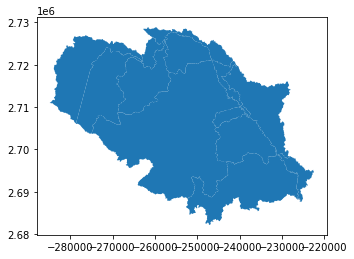

In [6]:
gdf_ps.plot()

### Read the climate cbh file (netCDF format) and map to geopandas for plotting
* Grab the dates from the initial model time

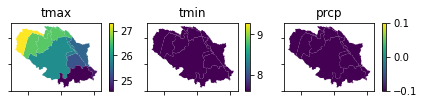

In [7]:
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
clim_file = Path('../prms/pipestem/daymet.nc')
clim = xr.open_dataset(clim_file)
ptime = m.var['nowtime'].data
timesel = dt.datetime(ptime[0], ptime[1], ptime[2])
start_date = timesel
gdf_ps['tmax'] = clim.tmax.sel(time=timesel)
gdf_ps['tmin'] = clim.tmin.sel(time=timesel)
gdf_ps['prcp'] = clim.prcp.sel(time=timesel)
fig, ax = plt.subplots(ncols=3)
divider0 = make_axes_locatable(ax[0])
divider1 = make_axes_locatable(ax[1])
divider2 = make_axes_locatable(ax[2])
cax0 = divider0.append_axes("right", size="5%", pad=0.1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
h_tmax = gdf_ps.tmax.max()
l_tmax = gdf_ps.tmax.min()
h_tmin= gdf_ps.tmin.max()
l_tmin= gdf_ps.tmin.min()
h_tmax = gdf_ps.tmax.max()
l_tmax = gdf_ps.tmax.min()
h_ppt= gdf_ps.prcp.max()
l_ppt= gdf_ps.prcp.min()

gdf_ps.plot(column='tmax', ax=ax[0], vmin=l_tmax, vmax=h_tmax, legend=True, label='tmax', cax=cax0)
gdf_ps.plot(column='tmin', ax=ax[1], vmin=l_tmin, vmax=l_tmin, legend=True, label='tmin', cax=cax1)
gdf_ps.plot(column='prcp', ax=ax[2], vmin=l_ppt, vmax=l_ppt, legend=True, label='prcp', cax=cax2)
for i in range(3):
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    if i == 0:
        ax[i].set_title('tmax')
    elif i == 1:
        ax[i].set_title('tmin')
    elif i == 2:
        ax[i].set_title('prcp')
plt.tight_layout()

### Get some model information
---

In [8]:
# Get time information from the model.
print('Start time:', m.start_time)
print('End time:', m.end_time)
print('Current time:', m.time)
print('Nowtime: ', m.var['nowtime'].data)

Start time: 0.0
End time: 13180.0
Current time: 0.0
Nowtime:  [1980    1    1    0    0    0]


### Run the PRMSSurface model for 372 days just prior to a precipiation event
---

In [9]:
m.update_until(372)
print('Current time:', m.time)
print('Nowtime: ', m.var['nowtime'].data)

Current time: 372.0
Nowtime:  [1981    1    6    0    0    0]


### Examine a variable through the BMI getter function
___

In [10]:
# Get variable info.
var_name = 'pkwater_ante'   # vector
# var_name = 'nhru'      # scalar
# var_name = 'dday_slope'  # rectilinear
print('Variable {}'.format(var_name))
print(' - variable type:', m.var_type(var_name))
print(' - units:', m.var_units(var_name))
print(' - itemsize:', m.var_itemsize(var_name))
print(' - nbytes:', m.var_nbytes(var_name))
print(' - location:', m.var_location(var_name))
type(m.get_value('pkwater_ante'))
print(m.get_value('pkwater_ante'))

Variable pkwater_ante
 - variable type: float64
 - units: in
 - itemsize: 8
 - nbytes: 112
 - location: node
[ 0.10643454  0.09124575  0.11888107  0.11036705  0.08721045  0.09764458
  0.11159246  0.10460883  0.09873197  0.08159178  0.11170992  0.09761866
  0.06800358  0.06729296]


### Run the model for an additional 7 days and examine the results time-step by time-step
----

[1981    1    7    0    0    0] 1981-01-07 00:00:00
[1981    1    8    0    0    0] 1981-01-08 00:00:00
[1981    1    9    0    0    0] 1981-01-09 00:00:00
[1981    1   10    0    0    0] 1981-01-10 00:00:00
[1981    1   11    0    0    0] 1981-01-11 00:00:00
[1981    1   12    0    0    0] 1981-01-12 00:00:00
[1981    1   13    0    0    0] 1981-01-13 00:00:00


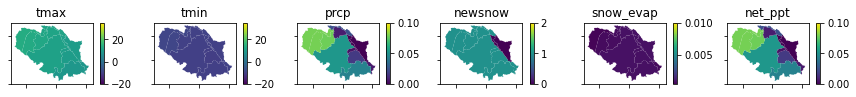

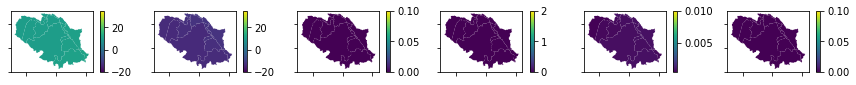

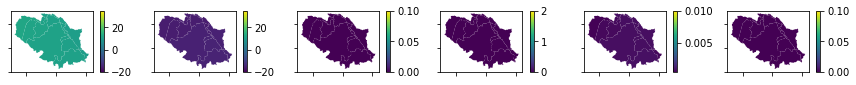

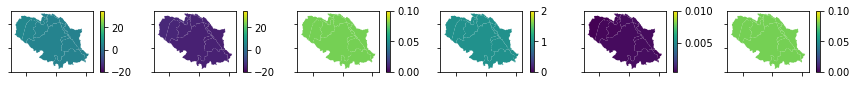

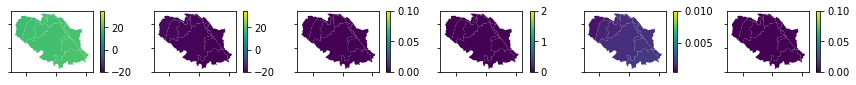

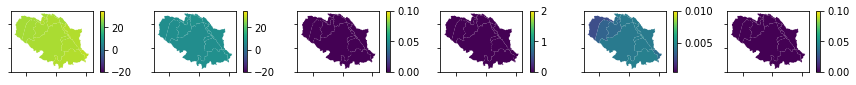

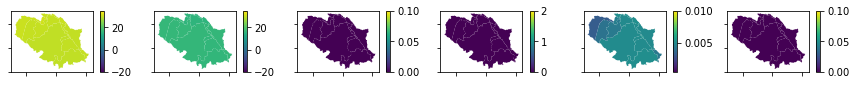

In [11]:

def example_plot(j, timesel):
    gdf_ps['tmax'] = clim.tmax.sel(time=timesel)
    gdf_ps['tmin'] = clim.tmin.sel(time=timesel)
    gdf_ps['prcp'] = clim.prcp.sel(time=timesel)

    gdf_ps['newsnow'] = m.var['newsnow'].data
    gdf_ps['snow_evap'] = m.var['snow_evap'].data
    gdf_ps['soil_moist_tot'] = m.var['net_ppt'].data

    fig, ax = plt.subplots(ncols=6, figsize = (12,2))
    divider0 = make_axes_locatable(ax[0])
    divider1 = make_axes_locatable(ax[1])
    divider2 = make_axes_locatable(ax[2])
    divider3 = make_axes_locatable(ax[3])
    divider4 = make_axes_locatable(ax[4])
    divider5 = make_axes_locatable(ax[5])
    cax0 = divider0.append_axes("right", size="5%", pad=0.1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    cax2 = divider2.append_axes("right", size="5%", pad=0.1)
    cax3 = divider3.append_axes("right", size="5%", pad=0.1)
    cax4 = divider4.append_axes("right", size="5%", pad=0.1)
    cax5 = divider5.append_axes("right", size="5%", pad=0.1)
    
    gdf_ps.plot(column='tmax', vmin=-20,  vmax= 35, ax=ax[0], legend=True, cax=cax0)
    gdf_ps.plot(column='tmin', vmin=-20,  vmax= 35, ax=ax[1], legend=True, cax=cax1)
    gdf_ps.plot(column='prcp', vmin=0,  vmax= .1, ax=ax[2], legend=True, cax=cax2)
    gdf_ps.plot(column='newsnow', vmin=0,  vmax= 2, ax=ax[3], legend=True, cax=cax3)
    gdf_ps.plot(column='snow_evap', vmin=.0005,  vmax= .01, ax=ax[4], legend=True, cax=cax4)
    gdf_ps.plot(column='net_ppt', vmin=0,  vmax= .1, ax=ax[5], legend=True, cax=cax5)
    for i in range(6):
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        if j == 0:
            if i == 0:
                ax[i].set_title('tmax')
            elif i == 1:
                ax[i].set_title('tmin')
            elif i == 2:
                ax[i].set_title('prcp')
            elif i == 3:
                ax[i].set_title('newsnow')
            elif i == 4:
                ax[i].set_title('snow_evap')
            elif i == 5:
                ax[i].set_title('net_ppt')
    plt.tight_layout()
    
for i in range(7):
    m.update()
    ptime = m.var['nowtime'].data
    timesel = dt.datetime(ptime[0], ptime[1], ptime[2])
    print(ptime, timesel)
    example_plot(i, timesel)

# finish running the model from the current time-step to the end
___

In [12]:
for i in range(int(m.time),int(m.end_time)):
    m.update()
    
print('Update: current time:', m.time)

Update: current time: 13180.0


In [13]:
ptime = m.var['nowtime'].data
end_date = dt.datetime(ptime[0], ptime[1], ptime[2])
print(end_date)

2016-01-31 00:00:00


### read the netcdf outputfile and plot some results for an hru
___

In [14]:
import xarray as xr
prms_file = Path('../prms/pipestem/output/summary_daily.nc')
pfile = xr.open_dataset(prms_file)
pfile

<xarray.Dataset>
Dimensions:              (nhru: 14, nsegment: 7, time: 13180)
Coordinates:
  * time                 (time) datetime64[ns] 1980-01-01 ... 2016-01-31
Dimensions without coordinates: nhru, nsegment
Data variables:
    nhm_id               (nhru) int32 ...
    nhm_seg              (nsegment) int32 ...
    hru_actet            (time, nhru) float32 ...
    hru_impervevap       (time, nhru) float32 ...
    hru_intcpevap        (time, nhru) float32 ...
    snow_evap            (time, nhru) float32 ...
    perv_actet           (time, nhru) float32 ...
    slow_flow            (time, nhru) float32 ...
    recharge             (time, nhru) float32 ...
    soil_moist           (time, nhru) float32 ...
    soil_to_gw           (time, nhru) float32 ...
    ssr_to_gw            (time, nhru) float32 ...
    dprst_seep_hru       (time, nhru) float64 ...
    dprst_evap_hru       (time, nhru) float32 ...
    infil                (time, nhru) float32 ...
    sroff                (time, nhru) float32 ...
    dunnian_flow         (time, nhru) float32 ...
    pkwater_equiv        (time, nhru) float64 ...
    snowmelt             (time, nhru) float32 ...
    soil_rechr           (time, nhru) float32 ...
    contrib_fraction     (time, nhru) float32 ...
    potet                (time, nhru) float32 ...
    basin_potet          (time) float64 ...
    basin_sroff          (time) float64 ...
    gwres_flow           (time, nhru) float32 ...
    gw_in_soil           (time, nhru) float64 ...
    gw_in_ssr            (time, nhru) float64 ...
    hru_outflow          (time, nhru) float64 ...
    seg_gwflow           (time, nsegment) float64 ...
    seg_sroff            (time, nsegment) float64 ...
    seg_ssflow           (time, nsegment) float64 ...
    seg_inflow           (time, nsegment) float64 ...
    seg_outflow          (time, nsegment) float64 ...
    seg_upstream_inflow  (time, nsegment) float64 ...

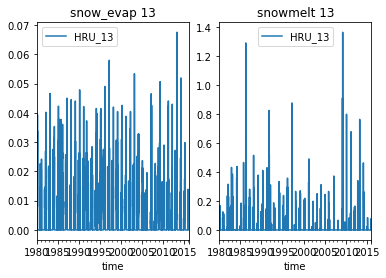

In [15]:
t_hru = 13

fig, ax = plt.subplots(ncols=2)
prms6bmi.bmi_prms6_value_plot(pfile, t_hru, 'snow_evap', 'HRU_13', start_date, end_date, ax[0])
prms6bmi.bmi_prms6_value_plot(pfile, t_hru, 'snowmelt', 'HRU_13', start_date, end_date, ax[1])

plt.show()

### Examples of some other capabilities of the PRMSSurface BMI through PyMT

In [16]:
# List the model's exchange items.
print('Number of input vars:', len(m.input_var_names))
for var in m.input_var_names:
    print(' - {}'.format(var))
print('Number of output vars:', len(m.output_var_names))
for var in m.output_var_names:
    print(' - {}'.format(var))

Number of input vars: 52
 - tmax
 - tmin
 - hortonian_lakes
 - soil_moist_max
 - soil_rechr_init_frac
 - soil_moist_init_frac
 - soil_rechr_max_frac
 - covden_sum
 - snow_intcp
 - covden_win
 - wrain_intcp
 - srain_intcp
 - epan_coef
 - jh_coef_hru
 - jh_coef
 - tmax_allrain_offset
 - tmax_allsnow
 - hru_ppt
 - adjmix_rain
 - rain_cbh_adj
 - snow_cbh_adj
 - va_open_exp
 - va_clos_exp
 - smidx_coef
 - smidx_exp
 - snowinfil_max
 - carea_max
 - imperv_stor_max
 - dprst_flow_coef
 - dprst_seep_rate_clos
 - dprst_depth_avg
 - dprst_area_max
 - dprst_frac
 - dprst_vol_clos
 - dprst_vol_open
 - hru_percent_imperv
 - snarea_curve
 - rad_trncf
 - cecn_coef
 - snarea_thresh
 - radmax
 - dday_slope
 - tmax_index
 - dday_intcp
 - tmax_cbh_adj
 - tmin_cbh_adj
 - transp_tmax
 - infil
 - sroff
 - soil_rechr
 - soil_moist
 - strm_seg_in
Number of output vars: 86
 - gsflow_mode
 - dprst_flag
 - cascade_flag
 - cascadegw_flag
 - cascadegw_flag
 - print_debug
 - hru_type
 - hru_area
 - cov_type
 - hru_r

In [17]:
# Get variable info.
var_name = 'hru_ppt'   # vector
# var_name = 'nhru'      # scalar
# var_name = 'dday_slope'  # rectilinear
print('Variable {}'.format(var_name))
print(' - variable type:', m.var_type(var_name))
print(' - units:', m.var_units(var_name))
print(' - itemsize:', m.var_itemsize(var_name))
print(' - nbytes:', m.var_nbytes(var_name))
print(' - location:', m.var_location(var_name))

Variable hru_ppt
 - variable type: float32
 - units: in
 - itemsize: 4
 - nbytes: 56
 - location: node


In [18]:
# Get grid info for variable.
grid_id = m.var_grid(var_name)
print(' - grid id:', grid_id)
print(' - grid type:', m.grid_type(grid_id))
print(' - rank:', m.grid_ndim(grid_id))

if m.grid_type(grid_id) == 'rectilinear':
    print(' - size:', m.grid_node_count(grid_id))
    print(' - shape:', m.grid_shape(grid_id))

print(' - x:', m.grid_x(grid_id))
print(' - y:', m.grid_y(grid_id))
print(' - z:', m.grid_z(grid_id))

if m.grid_type(grid_id) != 'rectilinear':
    print(' - node count:', m.grid_node_count(grid_id))
    print(' - face count:', m.grid_face_count(grid_id))
    print(' - edge count:', m.grid_edge_count(grid_id))

 - grid id: 0
 - grid type: vector
 - rank: 1
 - x: [-255338.765625 -244755.015625 -272161.75     -279352.53125  -239341.25
 -234624.84375  -262778.09375  -260845.5      -253183.8125   -252164.890625
 -242704.53125  -238578.578125 -226690.953125 -238430.328125]
 - y: [ 2703661.5   2718133.75  2714044.5   2715510.25  2702018.25  2710288.
  2715710.25  2722800.5   2722858.    2727314.5   2707931.    2709141.5
  2695859.    2691322.75]
 - z: [ 568.  483.  563.  564.  519.  483.  543.  503.  490.  489.  519.  474.
  476.  553.]
 - node count: 14
 - face count: 0
 - edge count: 13
